In [1]:
import random
import pennylane as qml
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import copy
from sklearn.metrics import roc_auc_score
import copy
import time
from typing import Any, Optional, Tuple, Callable
import mne
from sklearn.model_selection import train_test_split
import math

print('Pennylane Version :', qml.__version__)
print('Pytorch Version :', torch.__version__)
print('MNE Version :', mne.__version__)

/global/homes/j/junghoon/.local/perlmutter/python-3.11/lib/python3.11/site-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.4.34 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


Pennylane Version : 0.41.1
Pytorch Version : 2.5.0+cu121
MNE Version : 1.9.0


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Running on ", device)

Running on  cuda


In [3]:
def set_all_seeds(seed: int = 42) -> None:
    """Seed every RNG we rely on (Python, NumPy, Torch, PennyLane, CUDNN)."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)           # no-op on CPU
    torch.backends.cudnn.deterministic = True  # reproducible convolutions
    torch.backends.cudnn.benchmark = False
    os.environ["PL_GLOBAL_SEED"] = str(seed) 

# QCNN

In [4]:
class QCNN(nn.Module):
    def __init__(self, n_qubits=8, n_layers=2, input_dim=784, num_classes=10):
        """
        QCNN with classical dimensionality reduction and variational embedding for multi-class classification.

        Args:
            n_qubits (int): Number of qubits.
            n_layers (int): Number of convolutional & pooling layers.
            input_dim (int): Original input data dimensionality (e.g., MNIST image size).
            num_classes (int): Number of classes for classification.
        """
        super(QCNN, self).__init__()

        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.num_classes = num_classes

        # Classical dimension reduction (fully-connected layer)
        self.fc = nn.Linear(input_dim, n_qubits)
        # Quantum parameters
        self.conv_params = nn.Parameter(torch.randn(n_layers, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(n_layers, n_qubits // 2, 3))
        self.last_params = nn.Parameter(torch.randn(15))
        # Quantum device initialization
        self.dev = qml.device("default.qubit", wires=n_qubits)

    def circuit(self, conv_weights, pool_weights, last_weights, features):
        wires = list(range(self.n_qubits))
        # Variational Embedding (Angle Embedding)
        qml.AngleEmbedding(features, wires=wires, rotation='Y')
        for layer in range(self.n_layers):
            # Convolutional Layer
            self._apply_convolution(conv_weights[layer], wires)
            # Pooling Layer
            self._apply_pooling(pool_weights[layer], wires)
            wires = wires[::2]  # Retain every second qubit after pooling
        # Apply an arbitrary unitary gate to a specified set of wires.
        qml.ArbitraryUnitary(last_weights, wires)
        # Measurement: A single PauliZ to measure the state of the first qubit for binary classification
        return qml.expval(qml.PauliZ(0))

    def forward(self, x):
        # Classical dimension reduction
        reduced_x = self.fc(x)
        # Quantum Circuit Execution
        quantum_out = qml.qnode(self.dev, interface="torch")(self.circuit)(self.conv_params, self.pool_params, self.last_params, reduced_x)
        # Convert quantum output to logits for multi-class classification
        quantum_out = torch.stack(quantum_out, dim=1).float()
        return quantum_out

    def _apply_convolution(self, weights, wires):
        """
        Convolutional layer logic (same as original).
        """
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        # Pooling using a variational circuit
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

## Circuit Visualization

In [5]:
n_qubits = 8
n_layers = 2
classical_features = np.random.rand(8)

In [6]:
# Quantum parameters
conv_params = nn.Parameter(torch.randn(n_layers, n_qubits, 15))
pool_params = nn.Parameter(torch.randn(n_layers, n_qubits // 2, 3))
last_params = nn.Parameter(torch.randn(15))

# Quantum device initialization
dev = qml.device("default.qubit", wires=n_qubits)

def circuit(conv_weights, pool_weights, last_weights, features):
    wires = list(range(n_qubits))
    # Variational Embedding (Angle Embedding)
    qml.AngleEmbedding(features, wires=wires, rotation='Y')
    for layer in range(n_layers):
        # Convolutional Layer
        _apply_convolution(conv_weights[layer], wires)
        # Pooling Layer
        _apply_pooling(pool_weights[layer], wires)
        wires = wires[::2]  # Retain every second qubit after pooling
    # Apply an arbitrary unitary gate to a specified set of wires.
    qml.ArbitraryUnitary(last_weights, wires)
    # Measurement: A single PauliZ to measure the state of the first qubit for binary classification
    return qml.expval(qml.PauliZ(0))

def _apply_convolution(weights, wires):
    """
    Convolutional layer logic (same as original).
    """
    n_wires = len(wires)
    for p in [0, 1]:
        for indx, w in enumerate(wires):
            if indx % 2 == p and indx < n_wires - 1:
                qml.U3(*weights[indx, :3], wires=w)
                qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                qml.U3(*weights[indx, 9:12], wires=w)
                qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

def _apply_pooling(pool_weights, wires):
    # Pooling using a variational circuit
    n_wires = len(wires)
    assert n_wires >= 2, "Need at least two wires for pooling."
    for indx, w in enumerate(wires):
        if indx % 2 == 1 and indx < n_wires:
            measurement = qml.measure(w)
            qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

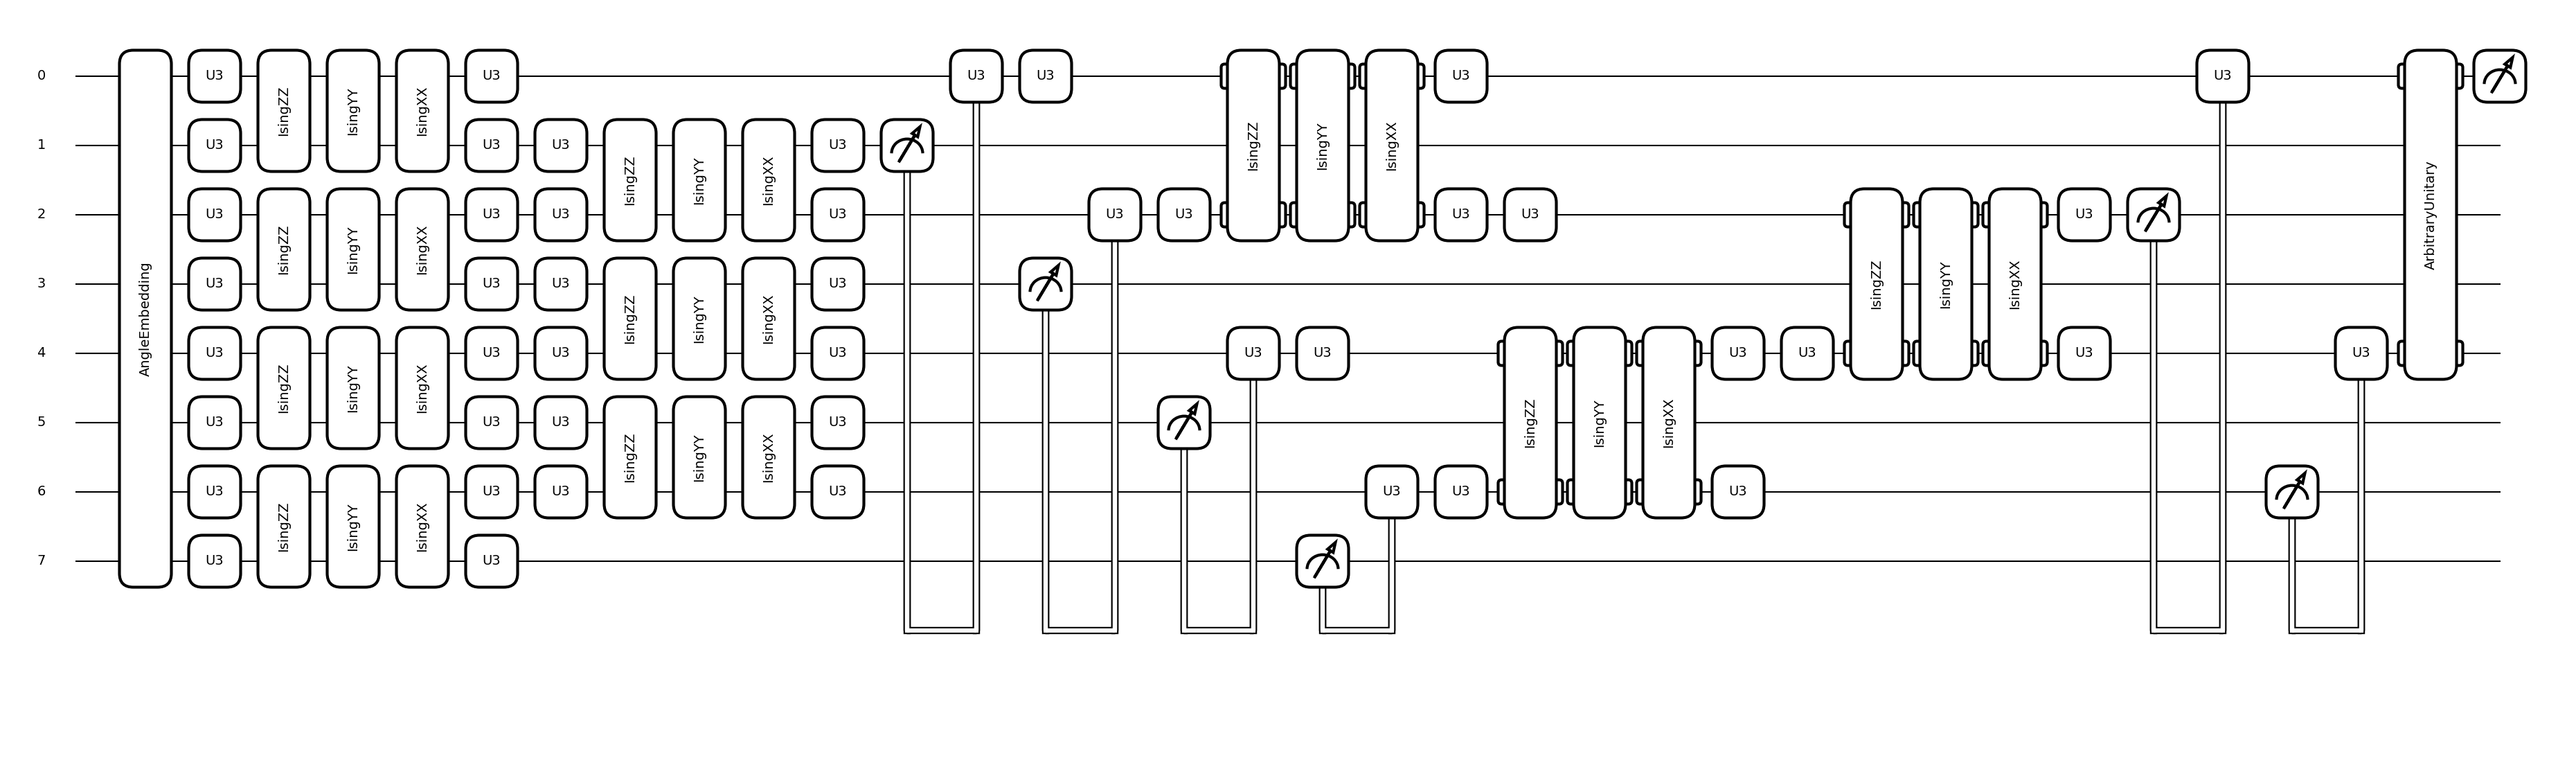

In [7]:
fig, ax = qml.draw_mpl(circuit)(conv_params, pool_params, last_params, classical_features)

# QTCN 1: QCNN + (Classical Dilation, Causal)

In [8]:
class QTCN(nn.Module):
    def __init__(self, n_qubits, circuit_depth, input_dim, kernel_size, dilation=1):
        super(QTCN, self).__init__()
        self.n_qubits = n_qubits
        self.circuit_depth = circuit_depth
        # Quantum parameters
        self.conv_params = nn.Parameter(torch.randn(circuit_depth, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))
        # Quantum device initialization
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        # The kernel size defines how many time steps we consider for the "convolution"
        self.input_channels = input_dim[1]
        self.time_steps = input_dim[2]
        self.kernel_size = kernel_size
        self.dilation = dilation
        
        # The input channels are treated as the feature size for each time step
        # Fully connected classical linear layer
        self.fc = nn.Linear(self.input_channels * self.kernel_size, n_qubits)  # For dimension reduction
        self.downsample = nn.Linear(self.input_channels * self.kernel_size, n_qubits)
        # self.fc_out = nn.Linear(self.time_steps - self.dilation * (self.kernel_size - 1), 1)  # Final output layer for Binary Classification

    def circuit(self, features):
        wires = list(range(self.n_qubits))    
        # Variational Embedding (Angle Embedding)
        qml.AngleEmbedding(features, wires=wires, rotation='Y')
        for layer in range(self.circuit_depth):
            # Convolutional Layer
            self._apply_convolution(self.conv_params[layer], wires)
            # Pooling Layer
            self._apply_pooling(self.pool_params[layer], wires)
            wires = wires[::2]  # Retain every second qubit after pooling
        # Measurement
        return qml.expval(qml.PauliZ(self.n_qubits-1))

    def _apply_convolution(self, weights, wires):
        """
        Convolutional layer logic (same as original).
        """
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        # Pooling using a variational circuit
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."

        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])
                
    def forward(self, x):
        # x has shape (batch_size, time_steps, input_channels)
        batch_size, input_channels, time_steps = x.size()
        # Quantum Circuit Execution
        quantum_circuit = qml.QNode(self.circuit, self.dev)
        # Initialize an empty list to store the output
        output = []
        # Slide a window of size `kernel_size` across the time steps (with dilation)
        for i in range(self.dilation * (self.kernel_size - 1), time_steps):
            indices = [i - d*self.dilation for d in range(self.kernel_size)]
            indices.reverse()
            window = x[:, :, indices].reshape(batch_size, -1)
            reduced_window = self.fc(window)
            output.append(quantum_circuit(reduced_window))
        # output = torch.stack(output, dim=1)
        # output = self.fc_out(output.float()).squeeze(1)
        output = torch.mean(torch.stack(output, dim=1), dim=1)
        return output

# QTCN2: Quantum Dilation Convolution

In [9]:
class QTCN2(nn.Module):
    """
    Quantum Temporal Convolutional Network (QTCN) using a QCNN-style ansatz.

    This model processes spatio-temporal data by:
    1. Using a classical Conv1D layer for feature extraction.
    2. Processing a sliding window of data (receptive field) on a quantum circuit.
    3. Applying dilated convolutions using a complex U3/Ising gate structure.
    4. Applying pooling using conditioned single-qubit unitary that depends on the measurement of a neighboring qubit.
    5. Applying dense layer that entangles all qubits of the final state using an all-to-all unitary gate.

    Args:
        input_channels (int): Number of features for each time step in the input data.
        n_qubits (int): The number of time steps the quantum circuit processes. This equals the number of qubits.
        n_layers (int): The number of stacked dilated convolutional layers.
    """

    def __init__(self, n_qubits=8, n_layers=2, input_channels=64):
        super(QTCN2, self).__init__()

        self.receptive_field_size = n_qubits
        self.n_layers = n_layers

        # 1. Classical Feature Extraction
        self.feature_extractor = nn.Conv1d(
            in_channels=input_channels,
            out_channels=1,
            kernel_size=1
        )

        # 2. Quantum Parameters
        self.conv_params = nn.Parameter(torch.randn(n_layers, 15))
        # Note: The size of pool_params might need adjustment depending on the pooling strategy
        self.pool_params = nn.Parameter(torch.randn(n_layers, n_qubits // 2, 3))
        self.last_params = nn.Parameter(torch.randn(15))

        # 3. Quantum Device and QNode
        self.dev = qml.device("default.qubit", wires=self.receptive_field_size)
        self.qnode = qml.QNode(self._circuit, self.dev)

    def _apply_dilated_conv(self, weights, dilation, wires):
        """
        Quantum dilated convolution that operates on the active wires list.
        Args:
            weights (torch.Tensor): The learnable parameters for this layer, shape (15,).
            dilation (int): The dilation factor (d).
            wires: The list of active wires.
        """
        num_active_wires = len(wires)
        # Loop over the indices of the active wires list
        for i in range(num_active_wires):
            # Check if the target wire is within the bounds of the active list
            if i + dilation < num_active_wires:
                # Get the actual qubit indices from the list
                w1 = wires[i]
                w2 = wires[i + dilation]

                # Apply the sequence of gates
                qml.U3(*weights[:3], wires=w1)
                qml.U3(*weights[3:6], wires=w2)
                qml.IsingZZ(weights[6], wires=[w1, w2])
                qml.IsingYY(weights[7], wires=[w1, w2])
                qml.IsingXX(weights[8], wires=[w1, w2])
                qml.U3(*weights[9:12], wires=w1)
                qml.U3(*weights[12:15], wires=w2)

    def _apply_pooling(self, pool_weights, wires):
        """Pooling using a variational circuit and measurement."""
        num_active_wires = len(wires)
        for i in range(num_active_wires // 2):
            w_control = wires[2*i]
            w_target = wires[2*i + 1]
            measurement = qml.measure(w_target)
            qml.cond(measurement, qml.U3)(*pool_weights[i], wires=w_control)

    def _circuit(self, features, conv_params, pool_params, last_params):
        """
        The quantum circuit combining dilated convolution and pooling.
        Args:
            features (torch.Tensor): A tensor of size (receptive_field_size,).
            conv_params (torch.Tensor): The learnable parameters for convolutional layers.
            pool_params (torch.Tensor): The learnable parameters for pooling layers.
            last_params (torch.Tensor): The learnable parameters for last layer.
        """
        wires = list(range(self.receptive_field_size))
        qml.AngleEmbedding(features, wires=wires, rotation='Y')

        for layer_idx in range(self.n_layers):
            dilation = 2**layer_idx
            # Pass the current active wires to the convolution function
            self._apply_dilated_conv(conv_params[layer_idx], dilation, wires)
            self._apply_pooling(pool_params[layer_idx], wires)
            # Reduce the number of active wires for the next layer
            wires = wires[::2]

        qml.ArbitraryUnitary(last_params, wires=wires)
        return qml.expval(qml.PauliZ(wires[0]))
    
    def forward(self, x):
        """
        The main forward pass implementing the "Conveyor Belt".
        Args:
            x (torch.Tensor): Input data of shape (batch_size, input_channels, time_steps).
        Returns:
            torch.Tensor: A tensor of predictions, shape (batch_size, num_predictions).
        """
        batch_size = x.shape[0]
        time_steps = x.shape[2]

        if time_steps < self.receptive_field_size:
            raise ValueError(f"Input time steps ({time_steps}) must be at least as large as the receptive field ({self.receptive_field_size}).")

        x = self.feature_extractor(x).squeeze(1)

        batch_predictions = []
        for i in range(batch_size):
            sample_sequence = x[i]
            window = sample_sequence[:self.receptive_field_size].clone()
            sequence_predictions = []

            for t in range(time_steps - self.receptive_field_size + 1):
                # The qnode is called for each window in the sequence
                q_out = self.qnode(window.cpu(), self.conv_params.cpu(), self.pool_params.cpu(), self.last_params.cpu())
                sequence_predictions.append(q_out.to(device))
                
                if t < time_steps - self.receptive_field_size:
                    window = torch.roll(window, shifts=-1, dims=0)
                    window[-1] = sample_sequence[t + self.receptive_field_size]

            batch_predictions.append(torch.stack(sequence_predictions))
        
        # Taking the mean of predictions over time for a final classification
        outputs = torch.mean(torch.stack(batch_predictions), dim=1)

        return outputs

## Circuit Visualization

In [10]:
receptive_field_size = 8
n_layers = 2
classical_features = np.random.rand(8)
conv_params = nn.Parameter(torch.randn(n_layers, 15))
pool_params = nn.Parameter(torch.randn(n_layers, receptive_field_size // 2, 3))
last_params = nn.Parameter(torch.randn(15))

In [11]:
def _apply_dilated_conv(weights, dilation, wires):
    """
    MODIFIED dilated convolution that operates on the active wires list.
    """
    num_active_wires = len(wires)
    # Loop over the indices of the active wires list
    for i in range(num_active_wires):
        # Check if the target wire is within the bounds of the active list
        if i + dilation < num_active_wires:
            # Get the actual qubit indices from the list
            w1 = wires[i]
            w2 = wires[i + dilation]

            # Apply the sequence of gates
            qml.U3(*weights[:3], wires=w1)
            qml.U3(*weights[3:6], wires=w2)
            qml.IsingZZ(weights[6], wires=[w1, w2])
            qml.IsingYY(weights[7], wires=[w1, w2])
            qml.IsingXX(weights[8], wires=[w1, w2])
            qml.U3(*weights[9:12], wires=w1)
            qml.U3(*weights[12:15], wires=w2)

def _apply_pooling(pool_weights, wires):
    """Pooling using a variational circuit and measurement."""
    num_active_wires = len(wires)
    for i in range(num_active_wires // 2):
        w_control = wires[2*i]
        w_target = wires[2*i + 1]
        measurement = qml.measure(w_target)
        qml.cond(measurement, qml.U3)(*pool_weights[i], wires=w_control)

def _circuit(features, conv_params, pool_params, last_params):
    """The quantum circuit combining dilation and pooling."""
    wires = list(range(receptive_field_size))
    qml.AngleEmbedding(features, wires=wires, rotation='Y')

    for layer_idx in range(n_layers):
        dilation = 2**layer_idx
        # Pass the current active wires to the convolution function
        _apply_dilated_conv(conv_params[layer_idx], dilation, wires)
        _apply_pooling(pool_params[layer_idx], wires)
        # Reduce the number of active wires for the next layer
        wires = wires[::2]

    qml.ArbitraryUnitary(last_params, wires=wires)
    return qml.expval(qml.PauliZ(wires[0]))

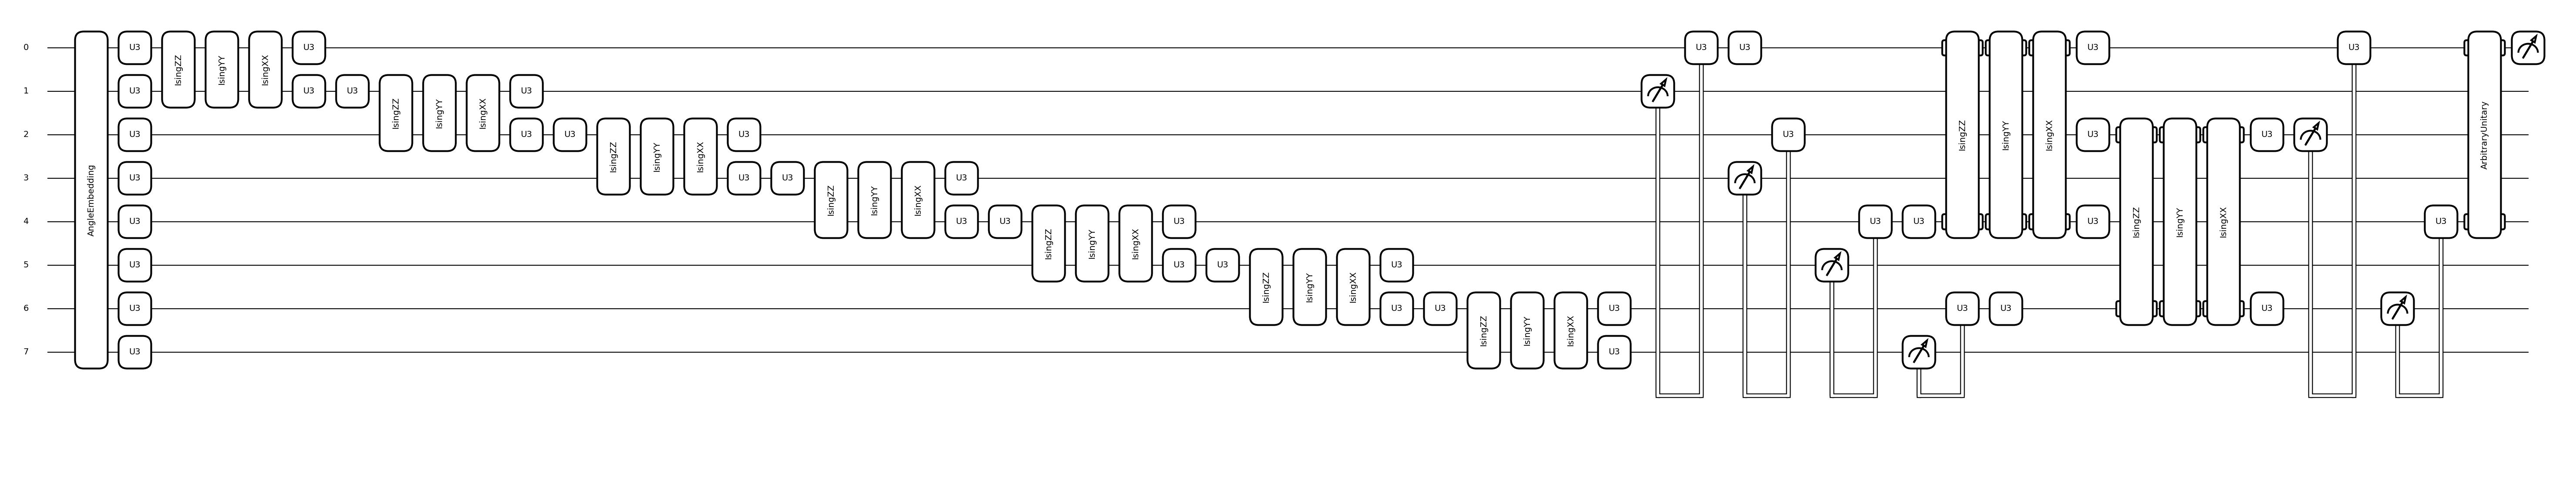

In [12]:
fig, ax = qml.draw_mpl(_circuit)(classical_features, conv_params, pool_params, last_params)

# QTCN 3: Quantum Causal Convolution

In [13]:
class QTCN3(nn.Module):
    """
    (THEORETICAL MODEL)
    A stateful, causal QTCN using the original QCNN convolution ansatz
    combined with a physical Quantum SWAP Chain.

    This model is causal and temporal, but not hierarchical.
    """

    def __init__(self, n_qubits=8, n_layers=2, input_channels=64, time_steps=20):
        super(QTCN3, self).__init__()
        
        if time_steps < n_qubits:
            raise ValueError("Total time_steps must be >= receptive_field_size.")
        if n_layers >= n_qubits.bit_length():
             raise ValueError("The number of layers would reduce qubits to zero.")

        self.receptive_field_size = n_qubits
        self.n_layers = n_layers
        self.input_channels = input_channels
        self.time_steps = time_steps

        # 1. Classical Feature Extraction
        self.feature_extractor = nn.Conv1d(
            in_channels=self.input_channels, out_channels=1, kernel_size=1)

        # 2. Quantum Parameters
        self.conv_params = nn.Parameter(torch.randn(n_layers, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(n_layers, n_qubits // 2, 3))
        self.last_params = nn.Parameter(torch.randn(15))

        # 3. Quantum Device and QNode
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.qnode = qml.QNode(self._circuit, self.dev)

    def _apply_convolution(self, weights, wires):
        """
        The QCNN-style convolutional layer you provided.
        It connects adjacent qubits in the provided wires list.
        """
        n_wires = len(wires)
        # The p-loop ensures all adjacent pairs are entangled
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    w1 = w
                    w2 = wires[indx + 1]
                    # Gate sequence applied to adjacent qubits
                    qml.U3(*weights[indx, :3], wires=w1)
                    qml.U3(*weights[indx + 1, 3:6], wires=w2)
                    qml.IsingZZ(weights[indx, 6], wires=[w1, w2])
                    qml.IsingYY(weights[indx, 7], wires=[w1, w2])
                    qml.IsingXX(weights[indx, 8], wires=[w1, w2])
                    qml.U3(*weights[indx, 9:12], wires=w1)
                    qml.U3(*weights[indx + 1, 12:], wires=w2)

    def _apply_pooling(self, pool_weights, wires):
        """Pooling using a variational circuit and measurement."""
        num_active_wires = len(wires)
        for i in range(num_active_wires // 2):
            w_control = wires[2*i]
            w_target = wires[2*i + 1]
            measurement = qml.measure(w_target)
            qml.cond(measurement, qml.U3)(*pool_weights[i], wires=w_control)
            
    def _apply_swap_shift(self):
        """
        Applies a SWAP chain to the ENTIRE physical register.
        q_state[i] -> q_state[i-1].
        """
        for i in range(self.receptive_field_size-1, 0, -1): 
            qml.SWAP(wires=[i, i-1])

    def _circuit(self, full_sequence, conv_params, pool_params, last_params):
        """
        A single, giant quantum circuit that processes an entire spatio-temporal evolution.
        
        Args:
            full_sequence (torch.Tensor): The full, pre-processed time series for ONE sample.
            conv_params (torch.Tensor): The learnable parameters for convolutional layers.
            pool_params (torch.Tensor): The learnable parameters for pooling layers.
            last_params (torch.Tensor): The learnable parameters for last layer.
        """   
        initial_window = full_sequence[:self.receptive_field_size]
        qml.AngleEmbedding(initial_window, wires=range(self.receptive_field_size))
        
        # Main temporal loop
        for t in range(self.time_steps - self.receptive_field_size + 1):
            active_wires = list(range(self.receptive_field_size))
            
            # Apply the convolutional layers
            for layer_idx in range(self.n_layers):
                self._apply_convolution(conv_params[layer_idx], active_wires)
                self._apply_pooling(pool_params[layer_idx], active_wires)
                # Reduce the number of active wires for the next layer
                active_wires = active_wires[::2]
            
            # --- Shift for Next Time Step (Time) ---
            if t < self.time_steps - self.receptive_field_size:
                self._apply_swap_shift()
                next_sample = full_sequence[t + self.receptive_field_size]
                qml.RY(next_sample, wires=self.receptive_field_size - 1)
        
        # --- Last Layer ---
        qml.ArbitraryUnitary(last_params, wires=active_wires)
        # --- Final Measurement ---
        # The single measurement is placed at the very end of the queue.
        return qml.expval(qml.PauliZ(active_wires[0]))
    
    def forward(self, x):
        """The classical wrapper for the monolithic quantum circuit."""
        batch_size = x.shape[0]
        x = self.feature_extractor(x).squeeze(1)

        batch_predictions = []
        for i in range(batch_size):
            prediction_for_sample = self.qnode(x[i], self.conv_params, self.pool_params, self.last_params)
            batch_predictions.append(prediction_for_sample)

        return torch.stack(batch_predictions)

## Circuit Visualization

In [14]:
receptive_field_size = 8
n_layers = 2
classical_features = np.random.rand(10)
conv_params = nn.Parameter(torch.randn(n_layers, receptive_field_size, 15))
pool_params = nn.Parameter(torch.randn(n_layers, receptive_field_size // 2, 3))
last_params = nn.Parameter(torch.randn(15))
time_steps=10

In [15]:
def _apply_convolution(weights, wires):
    n_wires = len(wires)
    # The p-loop ensures all adjacent pairs are entangled
    for p in [0, 1]:
        for indx, w in enumerate(wires):
            if indx % 2 == p and indx < n_wires - 1:
                w1 = w
                w2 = wires[indx + 1]
                # Gate sequence applied to adjacent qubits
                qml.U3(*weights[indx, :3], wires=w1)
                qml.U3(*weights[indx + 1, 3:6], wires=w2)
                qml.IsingZZ(weights[indx, 6], wires=[w1, w2])
                qml.IsingYY(weights[indx, 7], wires=[w1, w2])
                qml.IsingXX(weights[indx, 8], wires=[w1, w2])
                qml.U3(*weights[indx, 9:12], wires=w1)
                qml.U3(*weights[indx + 1, 12:], wires=w2)

def _apply_pooling(pool_weights, wires):
    """Pooling using a variational circuit and measurement."""
    num_active_wires = len(wires)
    for i in range(num_active_wires // 2):
        w_control = wires[2*i]
        w_target = wires[2*i + 1]
        measurement = qml.measure(w_target)
        qml.cond(measurement, qml.U3)(*pool_weights[i], wires=w_control)

def _apply_swap_shift():
    for i in range(receptive_field_size-1, 0, -1): 
        qml.SWAP(wires=[i, i-1])
        
def _circuit(full_sequence, conv_params, pool_params, last_params):
    initial_window = full_sequence[:receptive_field_size]
    qml.AngleEmbedding(initial_window, wires=range(receptive_field_size))

    # Main temporal loop: All operations are queued first.
    for t in range(time_steps - receptive_field_size + 1):
        # At the start of each time step, the "active" wires are the full set
        active_wires = list(range(receptive_field_size))
            
        # --- Inner Hierarchical Loop (Space) ---
        for layer_idx in range(n_layers):
            _apply_convolution(conv_params[layer_idx], active_wires)
            _apply_pooling(pool_params[layer_idx], active_wires)
            # Reduce the number of active wires for the next layer
            active_wires = active_wires[::2]
                        
        # --- Shift for Next Time Step (Time) ---
        if t < time_steps - receptive_field_size:
            _apply_swap_shift()
            next_sample = full_sequence[t + receptive_field_size]
            qml.RY(next_sample, wires=receptive_field_size - 1)

    # --- Last Layer ---
    qml.ArbitraryUnitary(last_params, wires=active_wires)
    # --- Final Measurement ---
    # The single measurement is placed at the very end of the queue.
    return qml.expval(qml.PauliZ(active_wires[0]))

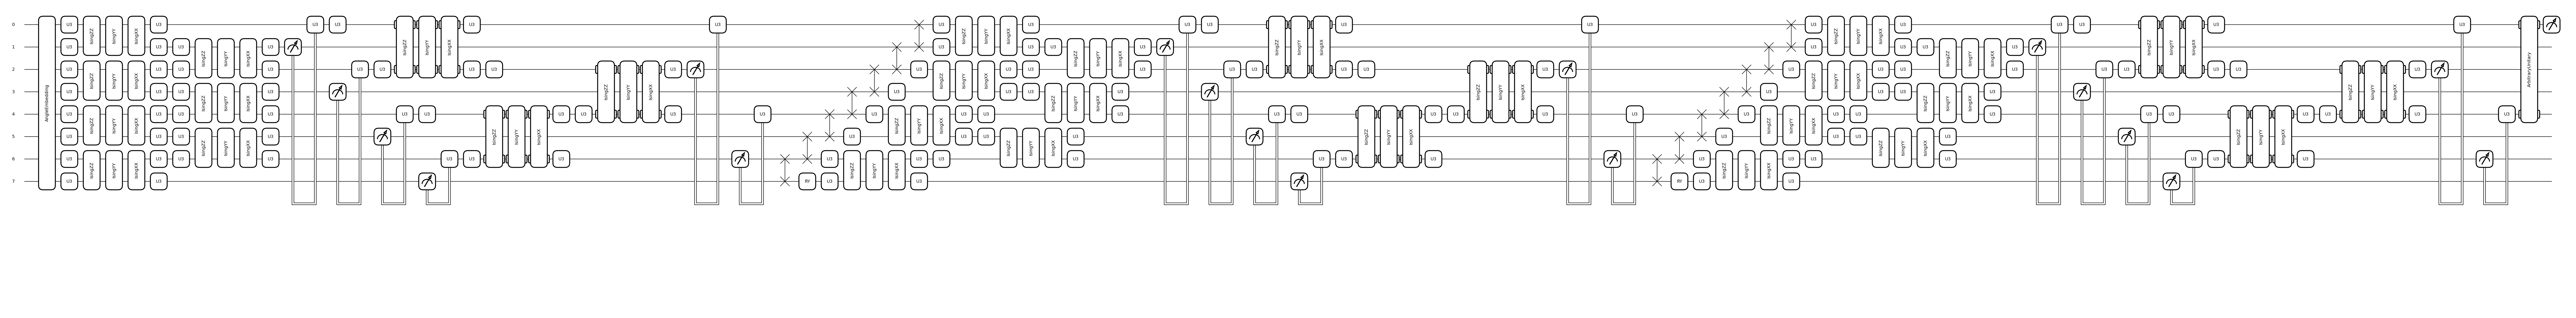

In [16]:
fig, ax = qml.draw_mpl(_circuit)(classical_features, conv_params, pool_params, last_params)

# QTCN 4: Quantum Convolution & Residual Block

## Circuit Visualization

# QTCN 5: Quantum Dilation, Causal Convolution

In [17]:
class QTCN5(nn.Module):
    """
    (ADVANCED THEORETICAL MODEL)
    QTCN combining a physical SWAP Chain with hierarchical qubit reduction (pooling).

    WARNING: This model represents an extremely deep and complex quantum circuit,
    far beyond the capabilities of any current hardware. It is for conceptual exploration.

    It processes an entire time-series within a single, stateful quantum circuit,
    using qml.SWAP gates to implement the "conveyor belt".

    Args:
        receptive_field_size (int): The number of qubits, defining the processing window.
        n_layers (int): The number of stacked dilated convolutional layers.
        input_channels (int): Number of features for each time step.
        time_steps (int): The total number of time steps in the input sequence.
    """
    
    def __init__(self, receptive_field_size=8, n_layers=2, input_channels=64, time_steps=20):
        super(QTCN5, self).__init__()
        
        if time_steps < receptive_field_size:
            raise ValueError("Total time_steps must be >= receptive_field_size.")
        if n_layers >= receptive_field_size.bit_length():
             raise ValueError("The number of layers would reduce qubits to zero.")

        self.receptive_field_size = receptive_field_size
        self.n_layers = n_layers
        self.time_steps = time_steps

        # 1. Classical Feature Extraction
        self.feature_extractor = nn.Conv1d(
            in_channels=input_channels, out_channels=1, kernel_size=1)

        # 2. Quantum Parameters
        self.conv_params = nn.Parameter(torch.randn(n_layers, 15))
        self.pool_params = nn.Parameter(torch.randn(n_layers, receptive_field_size // 2, 3))
        self.last_params = nn.Parameter(torch.randn(15))

        # 3. Quantum Device and QNode
        self.dev = qml.device("default.qubit", wires=self.receptive_field_size)
        self.qnode = qml.QNode(self._circuit, self.dev, interface="torch")
       
    def _apply_dilated_conv(self, weights, dilation, wires):
        """Dilated convolution that is AWARE of the active wires list."""
        num_active_wires = len(wires)
        for i in range(num_active_wires):
            if i + dilation < num_active_wires:
                w1, w2 = wires[i], wires[i + dilation]
                qml.U3(*weights[:3], wires=w1)
                qml.U3(*weights[3:6], wires=w2)
                qml.IsingZZ(weights[6], wires=[w1, w2])
                qml.IsingYY(weights[7], wires=[w1, w2])
                qml.IsingXX(weights[8], wires=[w1, w2])
                qml.U3(*weights[9:12], wires=w1)
                qml.U3(*weights[12:15], wires=w2)

    def _apply_pooling(self, pool_weights, wires):
        """Pooling using a variational circuit and measurement."""
        num_active_wires = len(wires)
        for i in range(num_active_wires // 2):
            w_control = wires[2*i]
            w_target = wires[2*i + 1]
            measurement = qml.measure(w_target)
            qml.cond(measurement, qml.U3)(*pool_weights[i], wires=w_control)

    def _apply_swap_shift(self):
        """
        Applies a SWAP chain to the ENTIRE physical register.
        q_state[i] -> q_state[i-1].
        """
        for i in range(receptive_field_size, 0, -1): 
            qml.SWAP(wires=[i, i-1])
        
    def _circuit(self, full_sequence, conv_params, pool_params, last_params):
        """
        A single, giant quantum circuit that processes an entire spatio-temporal evolution.
        
        Args:
            full_sequence (torch.Tensor): The full, pre-processed time series for ONE sample.
            conv_params (torch.Tensor): The learnable parameters for convolutional layers.
            pool_params (torch.Tensor): The learnable parameters for pooling layers.
            last_params (torch.Tensor): The learnable parameters for last layer.
        """        
        initial_window = full_sequence[:self.receptive_field_size]
        qml.AngleEmbedding(initial_window, wires=range(self.receptive_field_size))

        for t in range(self.time_steps - self.receptive_field_size + 1):
            # At the start of each time step, the "active" wires are the full set
            active_wires = list(range(self.receptive_field_size))
            
            # --- Inner Hierarchical Loop (Space) ---
            for layer_idx in range(self.n_layers):
                dilation = 2**layer_idx
                self._apply_dilated_conv(conv_params[layer_idx], dilation, active_wires)
                self._apply_pooling(pool_params[layer_idx], active_wires)
                # Reduce the list of active wires for the next hierarchical layer
                active_wires = active_wires[::2]
            
            # --- Shift for Next Time Step (Time) ---
            if t < self.time_steps - self.receptive_field_size:
                self._apply_swap_shift()
                next_sample = full_sequence[t + self.receptive_field_size]
                qml.RY(next_sample, wires=self.receptive_field_size - 1)

        # --- Last Layer ---
        qml.ArbitraryUnitary(last_params, wires=active_wires)
        # --- Final Measurement ---
        # The single measurement is placed at the very end of the queue.
        return qml.expval(qml.PauliZ(active_wires[0]))
    
    def forward(self, x):
        """The classical wrapper for the monolithic quantum circuit."""
        batch_size = x.shape[0]
        x = self.feature_extractor(x).squeeze(1)

        batch_predictions = []
        for i in range(batch_size):
            predictions_for_sample = self.qnode(x[i], self.conv_params, self.pool_params, self.last_params)
            batch_predictions.append(torch.stack(predictions_for_sample))

        return torch.stack(batch_predictions)

## Circuit Visualization

In [18]:
receptive_field_size = 8
n_layers = 2
classical_features = np.random.rand(10)
conv_params = nn.Parameter(torch.randn(n_layers, 15))
pool_params = nn.Parameter(torch.randn(n_layers, receptive_field_size // 2, 3))
last_params = nn.Parameter(torch.randn(15))
time_steps=10

In [19]:
def _apply_dilated_conv(weights, dilation, wires):
    num_active_wires = len(wires)
    for i in range(num_active_wires):
        if i + dilation < num_active_wires:
            w1, w2 = wires[i], wires[i + dilation]
            qml.U3(*weights[:3], wires=w1)
            qml.U3(*weights[3:6], wires=w2)
            qml.IsingZZ(weights[6], wires=[w1, w2])
            qml.IsingYY(weights[7], wires=[w1, w2])
            qml.IsingXX(weights[8], wires=[w1, w2])
            qml.U3(*weights[9:12], wires=w1)
            qml.U3(*weights[12:15], wires=w2)

def _apply_pooling(pool_weights, wires):
    """Pooling using a variational circuit and measurement."""
    num_active_wires = len(wires)
    for i in range(num_active_wires // 2):
        w_control = wires[2*i]
        w_target = wires[2*i + 1]
        measurement = qml.measure(w_target)
        qml.cond(measurement, qml.U3)(*pool_weights[i], wires=w_control)

def _apply_swap_shift():
    for i in range(receptive_field_size-1, 0, -1): 
        qml.SWAP(wires=[i, i-1])
        
def _circuit(full_sequence, conv_params, pool_params, last_params):
    initial_window = full_sequence[:receptive_field_size]
    qml.AngleEmbedding(initial_window, wires=range(receptive_field_size))

    # Main temporal loop: All operations are queued first.
    for t in range(time_steps - receptive_field_size + 1):
        # At the start of each time step, the "active" wires are the full set
        active_wires = list(range(receptive_field_size))
            
        # --- Inner Hierarchical Loop (Space) ---
        for layer_idx in range(n_layers):
            dilation = 2**layer_idx
            _apply_dilated_conv(conv_params[layer_idx], dilation, active_wires)
            _apply_pooling(pool_params[layer_idx], active_wires)
            # Reduce the list of active wires for the next hierarchical layer
            active_wires = active_wires[::2]
                        
        # --- Shift for Next Time Step (Time) ---
        if t < time_steps - receptive_field_size:
            _apply_swap_shift()
            next_sample = full_sequence[t + receptive_field_size]
            qml.RY(next_sample, wires=receptive_field_size - 1)

    # --- Last Layer ---
    qml.ArbitraryUnitary(last_params, wires=active_wires)
    # --- Final Measurement ---
    # The single measurement is placed at the very end of the queue.
    return qml.expval(qml.PauliZ(active_wires[0]))

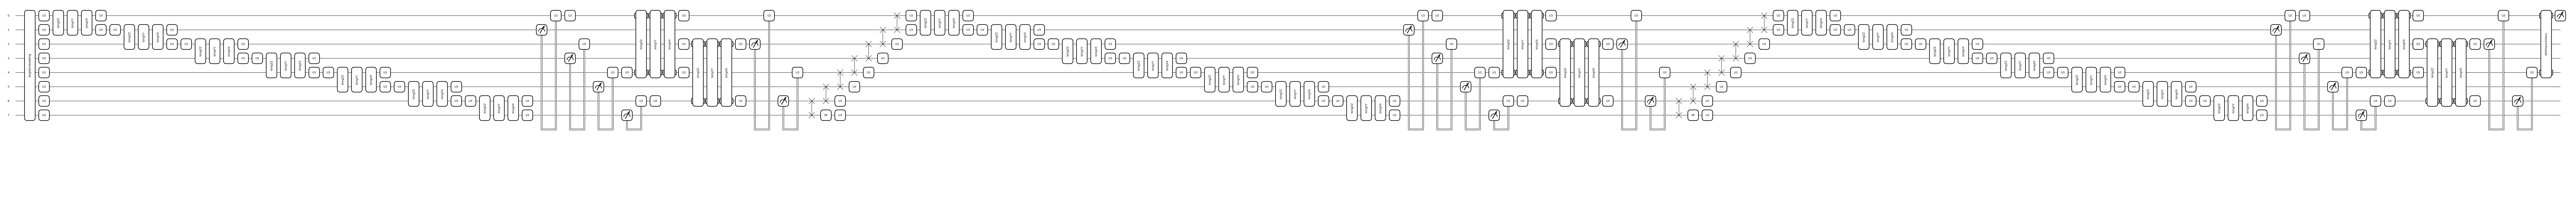

In [20]:
fig, ax = qml.draw_mpl(_circuit)(classical_features, conv_params, pool_params, last_params)

# QTCN 6: QCNN + Quantum Dilation, Causal, Residual

In [10]:
class QuantumResidualBlock(nn.Module):
    """A single quantum residual block."""
    def __init__(self, n_layers=1):
        super().__init__()
        # The transformation 'F' is a stack of dilated convolutions.
        # For simplicity, we'll use n_layers=1 here, meaning one dilation per block.
        # Parameters for the U3/Ising-based convolution
        self.conv_params = nn.Parameter(torch.randn(n_layers, 15))
        # The learnable parameter 'alpha' that controls the residual connection
        self.residual_param = nn.Parameter(torch.randn(1))

        
class QTCN6(nn.Module):
    """
    (THEORETICAL MODEL)
    QTCN with physical Quantum SWAP Chains and Quantum Residual Blocks.

    This version adds an ancilla qubit to control the application of each
    convolutional block, creating a quantum analogue of a residual connection.
    """
    def __init__(self, receptive_field_size=8, n_residual_blocks=3, input_channels=64, time_steps=20):
        super().__init__()
        
        if time_steps < receptive_field_size:
            raise ValueError("Total time_steps must be >= receptive_field_size.")

        self.receptive_field_size = receptive_field_size
        self.n_residual_blocks = n_residual_blocks
        self.input_channels = input_channels
        self.time_steps = time_steps

        # Main processing wires and a dedicated ancilla for residual control
        self.main_wires = list(range(receptive_field_size))
        self.ancilla_wire = receptive_field_size # The last qubit is the ancilla
        
        # 1. Classical Feature Extraction
        self.feature_extractor = nn.Conv1d(
            in_channels=self.input_channels, out_channels=1, kernel_size=1)

        # 2. Quantum Residual Blocks
        # Create a list of residual blocks, each with its own learnable parameters.
        # The dilation factor will be determined by the block's index.
        self.residual_blocks = nn.ModuleList(
            [QuantumResidualBlock(n_layers=1) for _ in range(n_residual_blocks)]
        )

        # 3. Quantum Device and QNode
        # The number of qubits is now receptive_field_size + 1 (for the ancilla)
        self.dev = qml.device("default.qubit", wires=receptive_field_size + 1)
        self.qnode = qml.QNode(self._circuit, self.dev, interface="torch")

    def _apply_conv_ansatz(self, weights, dilation):
        """The core U3/Ising convolution ansatz (our 'F' transformation)."""
        for i in range(self.receptive_field_size - dilation):
            w1, w2 = self.main_wires[i], self.main_wires[i + dilation]
            qml.U3(*weights[:3], wires=w1)
            qml.U3(*weights[3:6], wires=w2)
            qml.IsingZZ(weights[6], wires=[w1, w2])
            qml.IsingYY(weights[7], wires=[w1, w2])
            qml.IsingXX(weights[8], wires=[w1, w2])
            qml.U3(*weights[9:12], wires=w1)
            qml.U3(*weights[12:15], wires=w2)

    def _apply_residual_block(self, block, dilation):
        """Applies a full residual block using ancilla control."""
        # 1. Put ancilla into a superposition controlled by the learnable parameter
        qml.RY(block.residual_param[0], wires=self.ancilla_wire)
        # 2. Apply the convolution, controlled by the ancilla
        # The 'qml.ctrl' function makes an operation conditional on a control qubit.
        qml.ctrl(self._apply_conv_ansatz, control=self.ancilla_wire)(block.conv_params[0], dilation)
        # 3. Uncompute the rotation on the ancilla to disentangle it
        qml.RY(-block.residual_param[0], wires=self.ancilla_wire)

    def _apply_swap_shift(self):
        """Applies a SWAP chain to the main processing wires only."""
        # shift the register left by one → conveyor‑belt SWAPs
        for i in range(self.receptive_field_size - 1):
            qml.SWAP(wires=[self.main_wires[i], self.main_wires[i+1]])    

    def _circuit(self, full_sequence):
        """The main quantum circuit with residual blocks."""
        initial_window = full_sequence[:self.receptive_field_size]
        qml.AngleEmbedding(initial_window, wires=self.main_wires)
        predictions = []
        for t in range(self.time_steps - self.receptive_field_size + 1):
            # Apply the stack of residual blocks
            for block_idx, block in enumerate(self.residual_blocks):
                dilation = 2**block_idx
                if dilation >= self.receptive_field_size: continue # Skip if dilation is too large
                self._apply_residual_block(block, dilation)
            # If not the last step, shift the state and encode the next sample
            if t < self.time_steps - self.receptive_field_size:
                self._apply_swap_shift()
                next_sample = full_sequence[t + self.receptive_field_size]
                qml.RY(next_sample, wires=self.main_wires[-1])
        # Measure the last main qubit
        return qml.expval(qml.PauliZ(self.main_wires[-1]))
    
    def forward(self, x):
        """The forward pass."""
        batch_size = x.shape[0]
        x = self.feature_extractor(x).squeeze(1)

        batch_predictions = []
        for i in range(batch_size):
            predictions_for_sample = self.qnode(x[i])
            batch_predictions.append(predictions_for_sample)

        return torch.stack(batch_predictions)

## Circuit Visualization

In [60]:
receptive_field_size = 8
n_layers = 2
n_residual_blocks = 1
classical_features = np.random.rand(10)
conv_params = nn.Parameter(torch.randn(n_layers, 15))
time_steps=10

In [61]:
main_wires = list(range(receptive_field_size))
residual_blocks = nn.ModuleList(
    [QuantumResidualBlock(n_layers=1) for _ in range(n_residual_blocks)]
)
ancilla_wire = receptive_field_size # The last qubit is the ancilla

class QuantumResidualBlock(nn.Module):
    """A single quantum residual block."""
    def __init__(self, n_layers=1):
        super().__init__()
        # The transformation 'F' is a stack of dilated convolutions.
        # For simplicity, we'll use n_layers=1 here, meaning one dilation per block.
        # Parameters for the U3/Ising-based convolution
        self.conv_params = nn.Parameter(torch.randn(n_layers, 15))
        # The learnable parameter 'alpha' that controls the residual connection
        self.residual_param = nn.Parameter(torch.randn(1))
        
def _apply_conv_ansatz(weights, dilation):
    """
    Applies a single layer of causal, dilated convolution using the QCNN ansatz.

    Args:
        weights (torch.Tensor): The learnable parameters for this layer, shape (15,).
        dilation (int): The dilation factor (d).
    """
    # The 15 parameters are shared across all pairs in this layer,
    # achieving the "weight sharing" of a classical convolution.
    for i in range(n_qubits - dilation):
        # Define the pair of qubits for the dilated interaction
        w1 = i
        w2 = i + dilation

        # Apply the sequence of gates from the QCNN ansatz
        qml.U3(*weights[:3], wires=w1)
        qml.U3(*weights[3:6], wires=w2)
        qml.IsingZZ(weights[6], wires=[w1, w2])
        qml.IsingYY(weights[7], wires=[w1, w2])
        qml.IsingXX(weights[8], wires=[w1, w2])
        qml.U3(*weights[9:12], wires=w1)
        qml.U3(*weights[12:15], wires=w2)


def _apply_swap_shift():
    """
    Applies a chain of SWAP gates to shift the quantum state one step to the left.
    q_state[i] -> q_state[i-1].
    """
    # Must loop from right to left to avoid overwriting states before they are swapped.
    for i in range(receptive_field_size - 1):
        qml.SWAP(wires=[i, i+1])

def _apply_residual_block(block, dilation):
    """Applies a full residual block using ancilla control."""
    # 1. Put ancilla into a superposition controlled by the learnable parameter
    qml.RY(block.residual_param[0], wires=ancilla_wire)
    # 2. Apply the convolution, controlled by the ancilla
    # The 'qml.ctrl' function makes an operation conditional on a control qubit.
    qml.ctrl(_apply_conv_ansatz, control=ancilla_wire)(block.conv_params[0], dilation)
    # 3. Uncompute the rotation on the ancilla to disentangle it
    qml.RY(-block.residual_param[0], wires=ancilla_wire)

def _circuit(full_sequence):
    """The main quantum circuit with residual blocks."""
    initial_window = full_sequence[:receptive_field_size]
    qml.AngleEmbedding(initial_window, wires=main_wires)
    predictions = []
    for t in range(time_steps - receptive_field_size + 1):
        # Apply the stack of residual blocks
        for block_idx, block in enumerate(residual_blocks):
            dilation = 2**block_idx
            if dilation >= receptive_field_size: continue # Skip if dilation is too large
            _apply_residual_block(block, dilation)
        # If not the last step, shift the state and encode the next sample
        if t < time_steps - receptive_field_size:
            _apply_swap_shift()
            next_sample = full_sequence[t + receptive_field_size]
            qml.RY(next_sample, wires=main_wires[-1])
    # Measure the last main qubit
    return qml.expval(qml.PauliZ(main_wires[-1]))

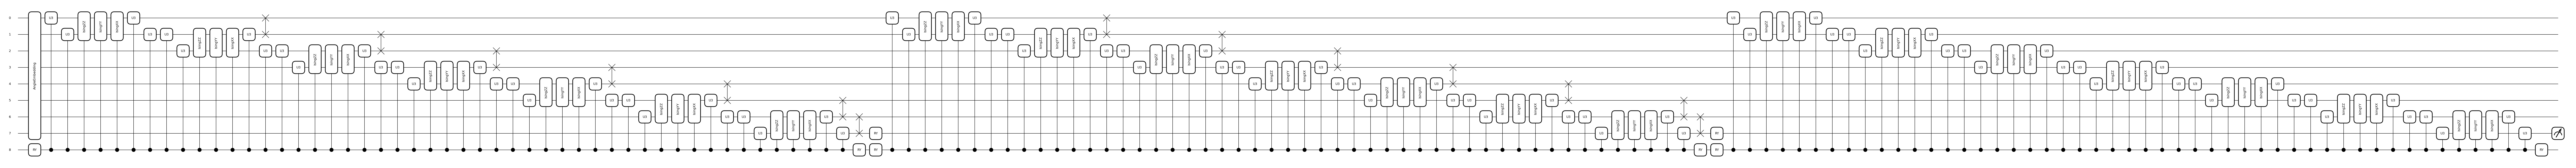

In [62]:
fig, ax = qml.draw_mpl(_circuit)(classical_features)

# Prepare PhysioNet EEG Dataset

Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. IEEE Transactions on Biomedical Engineering 51(6):1034-1043, 2004. https://mne.tools/stable/generated/mne.datasets.eegbci.load_data.html

In [13]:
def load_eeg_ts(seed, device, batch_size, sampling_freq):
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        
    # Load and preprocess the PhysioNet EEG Motor Imagery data
    N_SUBJECT = 50
    IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST = [4, 8, 12]

    # Load data from PhysioNet (example assumes data is downloaded locally)
    physionet_paths = [
        mne.datasets.eegbci.load_data(
            subjects=subj_id,
            runs=IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST,
            path="PhysioNet_EEG",
        ) for subj_id in range(1, N_SUBJECT+1)
    ]
    physionet_paths = np.concatenate(physionet_paths)

    # Ensuring that all subjects share same sampling frequency
    # TARGET_SFREQ = 160  # 160 Hz sampling rate
    TARGET_SFREQ = sampling_freq

    # Concatenate all loaded raw data
    parts = []
    for path in physionet_paths:
        raw = mne.io.read_raw_edf(
            path,
            preload=True,
            stim_channel='auto',
            verbose='WARNING',
        )
        # Resample raw data to ensure consistent sfreq
        raw.resample(TARGET_SFREQ, npad="auto")
        parts.append(raw)
        
    # Concatenate resampled raw data
    raw = mne.concatenate_raws(parts)

    # Pick EEG channels and extract events
    eeg_channel_inds = mne.pick_types(
        raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads'
    )
    events, _ = mne.events_from_annotations(raw)

    # Epoch the data
    epoched = mne.Epochs(
        raw, events, dict(left=2, right=3), tmin=1, tmax=4.1,
        proj=False, picks=eeg_channel_inds, baseline=None, preload=True
    )

    # Convert data to NumPy arrays
    X = (epoched.get_data() * 1e3).astype(np.float32)  # Convert to millivolts
    y = (epoched.events[:, 2] - 2).astype(np.int64)  # 0: left, 1: right
    
    # Train-validation-test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)
    
    def MakeTensorDataset(X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
        tensordataset = TensorDataset(X_tensor, y_tensor)
        return tensordataset
    
    # Create datasets and dataloaders
    train_dataset = MakeTensorDataset(X_train, y_train)
    val_dataset = MakeTensorDataset(X_val, y_val)
    test_dataset = MakeTensorDataset(X_test, y_test)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    input_dim = X_train.shape
    
    return train_loader, val_loader, test_loader, input_dim

# Train & Evaluation Functions

In [14]:
################################# Calculate Running Time ########################################
def epoch_time(start_time: float, end_time: float) -> Tuple[float, float]:
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


################################# Performance & Density Matrices ################################
# Training loop
def train_perf(model, dataloader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    all_labels = []
    all_outputs = []
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure that data is on the same device (GPU or CPU)
        labels = labels.float()   # Ensure labels are of type float for BCEWithLogitsLoss
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Collect labels and outputs for AUROC
        all_labels.append(labels.cpu().numpy())
        all_outputs.append(outputs.detach().cpu().numpy())       
        
    # Calculate train AUROC
    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    train_auroc = roc_auc_score(all_labels, all_outputs)
    
    return train_loss / len(dataloader), train_auroc


# Validation/Test loop
def evaluate_perf(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure that data is on the same device (GPU or CPU)
            labels = labels.float()   # Ensure labels are of type float for BCEWithLogitsLoss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Collect labels and outputs for AUROC
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    auroc = roc_auc_score(all_labels, all_outputs)
    
    return running_loss / len(dataloader), auroc

In [15]:
def QuantumTCNN_run(model_type, n_qubits, circuit_depth, input_dim, kernel_size=None, dilation=None, num_epochs=10):
    print("Running on ", device)
    if model_type==1:
        model = QTCN(n_qubits, circuit_depth, input_dim, kernel_size, dilation).to(device)
    elif model_type==2:
        model = QTCN2(n_qubits, circuit_depth, input_dim[1]).to(device)
    elif model_type==3:
        model = QTCN3(n_qubits=n_qubits, n_layers=circuit_depth, input_channels=input_dim[1], time_steps=input_dim[2]).to(device)
    elif model_type==5:
        model = QTCN5(n_qubits, circuit_depth, input_dim[1], input_dim[2]).to(device)
    elif model_type==6:
        model = QTCN6(n_qubits, circuit_depth, input_dim[1], input_dim[2]).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)
        
    # Training process
    train_metrics, valid_metrics, test_metrics = [], [], []
        
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        train_metrics.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_auc': train_auc})    
    
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        valid_metrics.append({'epoch': epoch + 1, 'valid_loss': valid_loss, 'valid_auc': valid_auc})
    
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    # Final evaluation on the test set
    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, AUC: {test_auc:.4f}")
    test_metrics.append({'epoch': num_epochs, 'test_loss': test_loss, 'test_auc': test_auc}) 

    # Combine all metrics into a pandas DataFrame
    metrics = []
    for epoch in range(num_epochs):
        metrics.append({
            'epoch': epoch + 1,
            'train_loss': train_metrics[epoch]['train_loss'],
            'train_auc': train_metrics[epoch]['train_auc'],
            'valid_loss': valid_metrics[epoch]['valid_loss'],
            'valid_auc': valid_metrics[epoch]['valid_auc'],
            'test_loss': test_metrics[0]['test_loss'],
            'test_auc': test_metrics[0]['test_auc'],
        })
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics)
    # Save to CSV
    csv_filename = f"QuantumTCNN{model_type}_performance.csv"
    metrics_df.to_csv(csv_filename, index=False)
    print(f"Metrics saved to {csv_filename}")
        
    return test_loss, test_auc

# Load Dataset

In [16]:
train_loader, val_loader, test_loader, input_dim = load_eeg_ts(seed=2025, device=device, batch_size=32, sampling_freq=4)

Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
2250 matching events found
No baseline correction applied
Using data from preloaded Raw for 2250 events and 13 original time points ...
116 bad epochs dropped


In [17]:
input_dim

(1493, 64, 13)

# Run Models

In [28]:
QuantumTCNN_run(model_type=1, n_qubits=8, circuit_depth=2, input_dim=input_dim, kernel_size=6, dilation=2, num_epochs=10)

Running on  cuda


100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


Epoch: 01 | Time: 0m 29s
Train Loss: 0.7499, AUC: 0.5382 | Validation Loss: 0.7420, AUC: 0.5576


100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


Epoch: 02 | Time: 0m 26s
Train Loss: 0.7264, AUC: 0.5656 | Validation Loss: 0.7209, AUC: 0.5543


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 03 | Time: 0m 26s
Train Loss: 0.7057, AUC: 0.5938 | Validation Loss: 0.7083, AUC: 0.5598


100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


Epoch: 04 | Time: 0m 26s
Train Loss: 0.6925, AUC: 0.5977 | Validation Loss: 0.6994, AUC: 0.5675


100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


Epoch: 05 | Time: 0m 25s
Train Loss: 0.6848, AUC: 0.6139 | Validation Loss: 0.6946, AUC: 0.5755


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


Epoch: 06 | Time: 0m 26s
Train Loss: 0.6804, AUC: 0.6292 | Validation Loss: 0.6914, AUC: 0.5829


100%|██████████| 10/10 [00:02<00:00,  4.45it/s]


Epoch: 07 | Time: 0m 25s
Train Loss: 0.6772, AUC: 0.6455 | Validation Loss: 0.6894, AUC: 0.5904


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


Epoch: 08 | Time: 0m 26s
Train Loss: 0.6745, AUC: 0.6571 | Validation Loss: 0.6867, AUC: 0.6017


100%|██████████| 10/10 [00:02<00:00,  4.80it/s]


Epoch: 09 | Time: 0m 26s
Train Loss: 0.6718, AUC: 0.6714 | Validation Loss: 0.6854, AUC: 0.6112


100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


Epoch: 10 | Time: 0m 27s
Train Loss: 0.6698, AUC: 0.6850 | Validation Loss: 0.6839, AUC: 0.6206


100%|██████████| 11/11 [00:02<00:00,  4.13it/s]

Test Loss: 0.6715, AUC: 0.6881
Metrics saved to QuantumTCNN1_performance.csv


(0.6715363426641985, 0.6880820836621941)

In [ ]:
QuantumTCNN_run(model_type=2, n_qubits=8, circuit_depth=2, input_dim=input_dim, kernel_size=None, dilation=None, num_epochs=10)

Running on  cuda


100%|██████████| 10/10 [01:17<00:00,  7.73s/it]


Epoch: 01 | Time: 16m 30s
Train Loss: 0.6939, AUC: 0.4703 | Validation Loss: 0.6932, AUC: 0.5241


100%|██████████| 10/10 [01:18<00:00,  7.90s/it]


Epoch: 02 | Time: 16m 2s
Train Loss: 0.6932, AUC: 0.4875 | Validation Loss: 0.6931, AUC: 0.5312


  2%|▏         | 1/47 [00:17<13:05, 17.09s/it]

In [28]:
QuantumTCNN_run(model_type=3, n_qubits=8, circuit_depth=2, input_dim=input_dim, kernel_size=None, dilation=None, num_epochs=10)

Running on  cuda


  0%|          | 0/47 [00:00<?, ?it/s]


WireError: Cannot run circuit(s) on lightning.qubit as they contain wires not found on the device: {8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43}

In [ ]:
QuantumTCNN_run(model_type=5, n_qubits=8, circuit_depth=2, input_dim=input_dim, kernel_size=None, dilation=None, num_epochs=10)